In [43]:
%pip install --upgrade torchvision

Note: you may need to restart the kernel to use updated packages.


In [44]:
import torch
from torchvision.datasets import Imagenette
from torchvision.transforms import transforms
import torch.nn as nn
import matplotlib.pyplot as pyplot
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [45]:
# !pip install tensorboard

## Device Agnostic Code


In [46]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Preparing Data

In [47]:
mean=[0.485, 0.456, 0.406]
std= [0.229, 0.224, 0.225]

In [48]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(227),
    transforms.Normalize(mean,std)
    ]
)

train_data=Imagenette(root='/kaggle/input/imagenette/data',split='train',download=False,transform=transform)
val_data=Imagenette(root='/kaggle/input/imagenette/data/val',split='val',download=False,transform=transform)


### Making Dataloader

In [49]:
train_dataloader=DataLoader(train_data,batch_size=128,shuffle=True)
val_dataloader=DataLoader(val_data,batch_size=128)

In [50]:
train_data,val_data

(Dataset Imagenette
     Number of datapoints: 9469
     Root location: /kaggle/input/imagenette/data
     StandardTransform
 Transform: Compose(
                ToTensor()
                CenterCrop(size=(227, 227))
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset Imagenette
     Number of datapoints: 3925
     Root location: /kaggle/input/imagenette/data/val
     StandardTransform
 Transform: Compose(
                ToTensor()
                CenterCrop(size=(227, 227))
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

# Building Alexnet Architecture

In [51]:
class Alexnet(nn.Module):

    def __init__(self, in_channel=3, out_classes=10):
        super().__init__()

        self.in_channel = in_channel
        self.out_classes = out_classes

        self.model = nn.Sequential(

            # conv->maxpool->conv->maxpool->3*conv->maxpool->3*fc->outputlayer
            nn.Conv2d(self.in_channel, 96, 11, 4),
            nn.ReLU(),
            nn.LocalResponseNorm(5, 0.001, 0.75, 2),
            nn.MaxPool2d(3, 2),
            nn.Conv2d(96, 256, 5, 1, padding='same'),
            nn.ReLU(),
            nn.LocalResponseNorm(5, 0.001, 0.75, 2),
            nn.MaxPool2d(3, 2),

            nn.Conv2d(256, 384, 3, 1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),

            # fully connected layer
            nn.Flatten(start_dim=1),
            nn.Linear(256*6*6, 4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.Dropout(0.5),
            nn.Linear(4096, self.out_classes),

        )

    def forward(self, x):
        return self.model(x)


In [52]:
alexnet=Alexnet()
alexnet.to(device)

Alexnet(
  (model): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=9216, out_features=4096, bias=True)
    (17): Dropout(p=0.5, inplace=False)
    (1

## Train the Model

In [53]:
optim=torch.optim.SGD(alexnet.parameters(),lr=0.01,momentum=0.9)

In [54]:
loss_train=[]
loss_test=[]
acc_train=[]
acc_test=[]

writer1 = SummaryWriter()
writer2 = SummaryWriter()

In [55]:
for epoch in range(20):
    running_loss=0
    count=0
    train_accuracy=0
    trunning_lost=0
    tcount=0
    val_accuracy=0

    for idx,data in enumerate(train_dataloader):
        count+=1
        optim.zero_grad()

        img,label=data
        logits=alexnet(img.to(device))

        loss=(torch.nn.functional.cross_entropy(logits,label.to(device)))

        loss.backward()
        optim.step()

        running_loss+=loss
        train_accuracy+=(torch.sum(torch.where(logits.argmax(1)==label.to(device), 1, 0)))

    with torch.no_grad():
      for t_idx,t_data in enumerate(val_dataloader):
        tcount+=1
        timg,tlabel=t_data
        t_logits=alexnet(timg.to(device))
        tloss=(torch.nn.functional.cross_entropy(t_logits,tlabel.to(device)))

        trunning_lost+=tloss
        val_accuracy+=(torch.sum(torch.where(t_logits.argmax(1)==tlabel.to(device), 1, 0)))


    # adding losses to the list
    loss_train.append((running_loss/count).item())
    loss_test.append((trunning_lost/tcount).item())

    # adding accuracy values to the list
    acc_train.append((train_accuracy/9469).item())
    acc_test.append((val_accuracy/3925).item())

    writer1.add_scalars('Loss Curve',{'Train':(running_loss/count).item(),
                                    'Validation': (trunning_lost/tcount).item()},epoch)
    
    writer2.add_scalars('Accuracy Curve',{'Train':(train_accuracy/9469).item(),
                                'Validation': (val_accuracy/3925).item()},epoch)

    print(f'Epoch: {epoch} | Training Loss: {(running_loss/count): .3f} | Train-Accuracy: {train_accuracy/9469: .3f} \
           Validation Loss: {(trunning_lost/tcount): .3f} | Validation Accuracy: {val_accuracy/3925: .3f}')
    
writer1.close()
writer2.close()


Epoch: 0 | Training Loss:  2.299 | Train-Accuracy:  0.105            Validation Loss:  2.289 | Validation Accuracy:  0.114
Epoch: 1 | Training Loss:  2.211 | Train-Accuracy:  0.183            Validation Loss:  2.103 | Validation Accuracy:  0.221
Epoch: 2 | Training Loss:  2.052 | Train-Accuracy:  0.266            Validation Loss:  1.993 | Validation Accuracy:  0.297
Epoch: 3 | Training Loss:  1.874 | Train-Accuracy:  0.341            Validation Loss:  1.810 | Validation Accuracy:  0.364
Epoch: 4 | Training Loss:  1.753 | Train-Accuracy:  0.397            Validation Loss:  1.686 | Validation Accuracy:  0.427
Epoch: 5 | Training Loss:  1.628 | Train-Accuracy:  0.444            Validation Loss:  1.546 | Validation Accuracy:  0.491
Epoch: 6 | Training Loss:  1.489 | Train-Accuracy:  0.507            Validation Loss:  1.518 | Validation Accuracy:  0.487
Epoch: 7 | Training Loss:  1.353 | Train-Accuracy:  0.557            Validation Loss:  1.585 | Validation Accuracy:  0.487
Epoch: 8 | Train

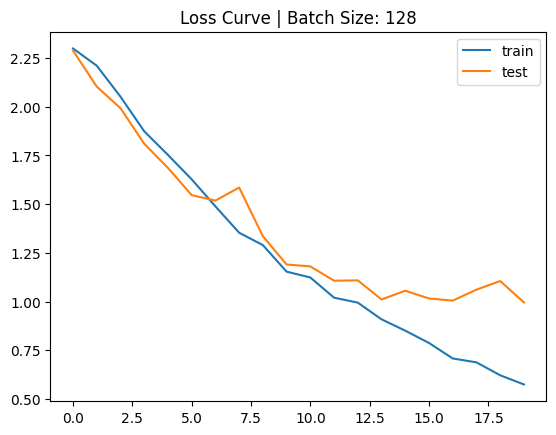

In [59]:
plt.plot(loss_train,label="train")
plt.plot(loss_test,label='test')
plt.title("Loss Curve | Batch Size: 128")
plt.legend()
plt.show()

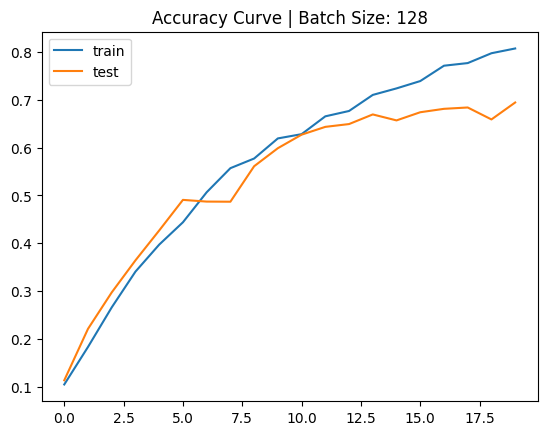

In [60]:
plt.plot(acc_train,label="train")
plt.plot(acc_test,label='test')
plt.title("Accuracy Curve | Batch Size: 128")
plt.legend()
plt.show()

## Saving the Model

In [61]:
torch.save(alexnet.state_dict(),'alexnetr.pt')